In [4]:
### Enter the path to the experiment folder
path = r"/media/will/3930-2B1A/LL_HL_LL_09_07_19/Experiment1"


import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import stats

dir_list = os.listdir(path)


# load report
for f in dir_list:
    if (f.endswith(".CSV") or f.endswith(".csv")) and not f.startswith("Results"):
        file_path = path+"/"+str(f)
        Report_DF = pd.read_csv(file_path,sep=';',skiprows=1)
        Report_DF = Report_DF[Report_DF["ID"]=="SP"]

FK_columns = ["P700 k","P700 r value", "P700 p value", "P700 std err", "PC k","PC r value", "PC p value", "PC std err","Fd k","Fd r value", "Fd p value", "Fd std err","P700 t1/2","PC t1/2","Fd t1/2"]
FK_data = []
for fk in os.listdir(path+"/FastKinetics"):
    fastkin_df = pd.read_csv(path+"/FastKinetics"+"/"+fk,sep=';',skiprows=1)
    pulse_width = 300

    cols_to_normalise = ["PC rel.","P700 rel.","Fd rel."]
    x = fastkin_df[cols_to_normalise[:]].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    normalised_df = pd.DataFrame(x_scaled,columns = cols_to_normalise)
    
    # DIRK initial rate (linear fit)
    DIRK_df = normalised_df[(fastkin_df["time/ms"]>=pulse_width) & (fastkin_df["time/ms"]<=pulse_width+10)]
    DIRK_df["time/ms"]= pd.Series([x/2.0 for x in range(len(DIRK_df.index))], index = DIRK_df.index)
    
    
    # Generated linear fit
    P700_slope, P700_intercept, P700_r_value, P700_p_value, P700_std_err = stats.linregress(np.array(DIRK_df["time/ms"]),np.array(DIRK_df["P700 rel."]))
    PC_slope, PC_intercept, PC_r_value, PC_p_value, PC_std_err = stats.linregress(np.array(DIRK_df["time/ms"]),np.array(DIRK_df["PC rel."]))
    Fd_slope, Fd_intercept, Fd_r_value, Fd_p_value, Fd_std_err = stats.linregress(np.array(DIRK_df["time/ms"]),np.array(DIRK_df["Fd rel."]))
    
    
    
    # Half time determination 
    DIRK_HALFTIME_df = normalised_df[(fastkin_df["time/ms"]>=pulse_width)]
    DIRK_HALFTIME_df["time/ms"]= pd.Series([x/2.0 for x in range(len(DIRK_HALFTIME_df.index))], index = DIRK_HALFTIME_df.index)
    
    # second normalisation and baseline correction
    
    cols_to_normalise = ["PC rel.","P700 rel.","Fd rel."]
    DIRK_HALFTIME_df["PC rel."] -= np.mean(np.array(DIRK_HALFTIME_df["PC rel."])[-100:])
    DIRK_HALFTIME_df["PC rel."] /= np.mean(np.array(DIRK_HALFTIME_df["PC rel."])[:3])
    
    DIRK_HALFTIME_df["P700 rel."] -= np.mean(np.array(DIRK_HALFTIME_df["P700 rel."])[-100:])
    DIRK_HALFTIME_df["P700 rel."] /= np.mean(np.array(DIRK_HALFTIME_df["P700 rel."])[:3])
    
    DIRK_HALFTIME_df["Fd rel."] = 1 - DIRK_HALFTIME_df["Fd rel."]
    DIRK_HALFTIME_df["Fd rel."] -= np.mean(np.array(DIRK_HALFTIME_df["Fd rel."])[-100:])
    DIRK_HALFTIME_df["Fd rel."] /= np.mean(np.array(DIRK_HALFTIME_df["Fd rel."])[:3])
    
    DIRK_HALFTIME_df["Fd rel."] = DIRK_HALFTIME_df.rolling(window=2).mean() # to smooth out the noisy Fd signal
    
    # Find Half-time (+/- 10 %)
    P700_HT = np.mean(np.array(DIRK_HALFTIME_df[(DIRK_HALFTIME_df["P700 rel."]<=0.55) & (DIRK_HALFTIME_df["P700 rel."]>=0.45)]["time/ms"]))
    PC_HT = np.mean(np.array(DIRK_HALFTIME_df[(DIRK_HALFTIME_df["PC rel."]<=0.55) & (DIRK_HALFTIME_df["PC rel."]>=0.45)]["time/ms"]))
    Fd_HT = np.mean(np.array(DIRK_HALFTIME_df[(DIRK_HALFTIME_df["Fd rel."]<=0.55) & (DIRK_HALFTIME_df["Fd rel."]>=0.45)]["time/ms"]))
    
    FK_data.append([P700_slope,P700_r_value, P700_p_value, P700_std_err,PC_slope,PC_r_value, PC_p_value, PC_std_err, Fd_slope,Fd_r_value, Fd_p_value, Fd_std_err, P700_HT, PC_HT, Fd_HT])
    
    # plot DIRK
    
    if not os.path.exists(path+"/DIRK_Halftime"):
        os.makedirs(path+"/DIRK_Halftime")
 
    else:
        pass
    
    for column in cols_to_normalise:
        fig=plt.figure()
        ax=fig.add_subplot(111)
        ax.set_xlabel("Time (ms)")
        plt.scatter(np.array(DIRK_HALFTIME_df["time/ms"]),np.array(DIRK_HALFTIME_df[column]),s=0.1,color='k')

        plt.savefig(path+"/DIRK_Halftime/"+column+fk[:-4]+".png",format='png',dpi=600)
        plt.clf()
        plt.cla()
        plt.close('all')

DIRK_results_df = pd.DataFrame(columns = FK_columns, data = np.array(FK_data), index = Report_DF.index )
        
results_df = pd.merge(Report_DF,DIRK_results_df,on = Report_DF.index)
results_df = results_df[['Date', 'Time', 'Rec.Time', 'Action', 'ID', 'Name', 'Temp',
       'PAR', 'F(I)', "Fo,Fo'", "Fm,Fm'", 'FMTm', 'F', 'Y(II)', 'Y(4S)',
       'ETR(II)', 'Y(NO)', 'Y(NPQ)', 'NPQ', 'qN', 'qP', 'qL', 'F/Fm', "Fm'/Fm",
       'P700ox', "P700m,P700m'", 'Y(I)', 'Y(ND)', 'Y(NA)', 'ETR(I)', 'PCox',
       "PCm,PCm'", 'Rel PCox', "Rel PCm'", 'Fdred', "Fdm,Fdm'", 'Rel Fdred',
       "Rel Fdm'", "P700 k","P700 r value", "P700 p value", "P700 std err", 
                         "PC k","PC r value", "PC p value", "PC std err","Fd k",
                         "Fd r value", "Fd p value", "Fd std err","P700 t1/2","PC t1/2","Fd t1/2"]]

# Make a time column in seconds/minutes from start
time_in_seconds = []
time_in_minutes = []
for i in results_df["Time"]:
    t = i.split(":")
    s = int(t[1])*60 + int(t[2])
    m = float(t[1]) + float(t[2])/60.0
    time_in_seconds.append(s)
    time_in_minutes.append(m)
results_df["Time/s"] = pd.Series(time_in_seconds,index=results_df.index)
results_df["Time/min"] = pd.Series(time_in_minutes,index=results_df.index)

# other engineered features (1-qL, YI/YII, ETR(I)-ETR(II))
results_df["1-qL"] = 1 - results_df["qL"]
results_df["Y(I)/Y(II)"] = results_df["Y(I)"] / results_df["Y(II)"]
results_df["ETR(I)-ETR(II)"] = results_df["ETR(I)"] - results_df["ETR(II)"]

results_df.to_csv(path+"/"+"Results.CSV")


/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import stats

Results1 = pd.read_csv(r"/media/will/3930-2B1A/LL_HL_LL_09_07_19/Exp_DIRK1/Results.CSV")
Results2 = pd.read_csv(r"/media/will/3930-2B1A/LL_HL_LL_09_07_19/Exp_DIRK2/Results.CSV")

Results1

,Unnamed: 0,Date,Time,Rec.Time,Action,ID,Name,Temp,PAR,F(I),...,Fd k,P700 t1/2,PC t1/2,Fd t1/2,Time/s,Time/min,1-qL,Y(I)/Y(II),ETR(I)-ETR(II),Class
0,0,09.07.19,00:00:11,00:00:11,Fm-Det.,SP,F_190709_000011_0,0,0,0,...,-0.003321,541.629032,563.304196,534.070000,11,0.183333,0.000,0.692199,0.000,Fm
1,1,09.07.19,00:00:32,00:00:32,P.+F. SP,SP,F_190709_000032_0,0,163,0,...,-0.002710,639.909091,500.166667,692.166667,32,0.533333,1.000,inf,2.751,N
2,2,09.07.19,00:00:40,00:00:40,P.+F. SP,SP,F_190709_000040_0,0,163,0,...,-0.001934,15.541667,50.510417,49.102041,40,0.666667,0.992,13.777778,15.739,N
3,3,09.07.19,00:01:00,00:01:00,P.+F. SP,SP,F_190709_000100_0,0,163,0,...,-0.002588,47.250000,146.150000,146.487179,60,1.000000,0.957,1.203704,0.752,N
4,4,09.07.19,00:01:30,00:01:30,P.+F. SP,SP,F_190709_000130_0,0,163,0,...,0.005797,31.500000,100.552632,100.777778,90,1.500000,0.934,1.946429,3.638,N
5,5,09.07.19,00:02:30,00:02:30,P.+F. SP,SP,F_190709_000230_0,0,163,0,...,0.002615,19.000000,58.520000,58.500000,150,2.500000,0.824,1.488000,4.174,N
6,6,09.07.19,00:04:30,00:04:30,P.+F. SP,SP,F_190709_000430_0,0,163,0,...,0.003840,12.750000,40.461538,40.961538,270,4.500000,0.787,1.554839,5.874,S
7,7,09.07.19,00:08:30,00:08:30,P.+F. SP,SP,F_190709_000830_0,0,163,0,...,0.002712,15.500000,49.750000,49.750000,510,8.500000,0.802,1.507463,4.686,S
8,8,09.07.19,00:16:30,00:16:30,P.+F. SP,SP,F_190709_001630_0,0,163,0,...,0.004378,18.071429,59.566667,60.100000,990,16.500000,0.839,1.710280,5.209,S
9,9,09.07.19,00:16:42,00:16:42,P.+F. SP,SP,F_190709_001642_0,0,1057,0,...,0.003091,18.500000,54.555556,54.842105,1002,16.700000,0.998,10.500000,8.360,N


In [7]:
Results = pd.concat([Results1,Results2])
Results_NSS = Results[Results["Class"]=="N"]
Results_SS = Results[Results["Class"]=="S"]

In [8]:
Results_NSS.describe()

,Unnamed: 0,Temp,PAR,F(I),"Fo,Fo'","Fm,Fm'",FMTm,F,Y(II),Y(4S),...,PC k,Fd k,P700 t1/2,PC t1/2,Fd t1/2,Time/s,Time/min,1-qL,Y(I)/Y(II),ETR(I)-ETR(II)
count,30.000000,30.0,30.000000,30.0,30.000000,30.000000,0.0,30.000000,30.000000,0.0,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,11.000000,0.0,461.000000,0.0,0.022000,0.031200,NaN,0.028633,0.111300,NaN,...,-0.005820,0.002825,54.614427,85.535724,94.422024,1054.400000,17.573333,0.832933,inf,6.745567
std,6.797565,0.0,428.640192,0.0,0.002034,0.016612,NaN,0.018322,0.083121,NaN,...,0.005186,0.004765,142.909016,131.562204,162.816287,819.185533,13.653092,0.143274,NaN,9.203042
min,1.000000,0.0,163.000000,0.0,0.020000,0.020000,NaN,0.015000,0.000000,NaN,...,-0.019572,-0.004785,10.250000,28.555556,28.812500,32.000000,0.533333,0.549000,0.250000,-22.621000
25%,4.250000,0.0,163.000000,0.0,0.020000,0.023000,NaN,0.019000,0.054250,NaN,...,-0.008194,-0.000855,12.312500,34.159091,34.375000,105.000000,1.750000,0.721000,1.262888,3.772000
50%,11.000000,0.0,163.000000,0.0,0.022000,0.025000,NaN,0.022500,0.083500,NaN,...,-0.005397,0.002853,15.145833,44.731731,45.000000,1030.000000,17.166667,0.877500,1.661460,7.881500
75%,17.750000,0.0,1057.000000,0.0,0.024000,0.027750,NaN,0.025000,0.171250,NaN,...,-0.003189,0.005786,18.875000,57.528889,57.585526,2008.000000,33.466667,0.951500,2.040666,12.436000
max,21.000000,0.0,1057.000000,0.0,0.024000,0.079000,NaN,0.084000,0.272000,NaN,...,0.005202,0.015091,639.909091,610.614754,692.166667,2120.000000,35.333333,1.000000,inf,19.260000


In [9]:
Results_SS.describe()

,Unnamed: 0,Temp,PAR,F(I),"Fo,Fo'","Fm,Fm'",FMTm,F,Y(II),Y(4S),...,PC k,Fd k,P700 t1/2,PC t1/2,Fd t1/2,Time/s,Time/min,1-qL,Y(I)/Y(II),ETR(I)-ETR(II)
count,18.000000,18.0,18.000000,18.0,18.000000,18.000000,0.0,18.000000,18.000000,0.0,...,18.000000,18.000000,18.000000,18.000000,18.000000,18.00000,18.000000,18.000000,18.000000,18.000000
mean,15.000000,0.0,461.000000,0.0,0.022000,0.023722,NaN,0.020333,0.144556,NaN,...,-0.006313,0.003430,13.809524,40.907521,41.098018,1570.00000,26.166667,0.773444,1.543010,6.287556
std,6.773651,0.0,433.653698,0.0,0.002058,0.002824,NaN,0.003029,0.078457,NaN,...,0.003461,0.006737,2.637941,10.643870,10.772055,883.05619,14.717603,0.127037,0.454807,8.524780
min,6.000000,0.0,163.000000,0.0,0.020000,0.019000,NaN,0.017000,0.012000,NaN,...,-0.012290,-0.012525,10.750000,28.250000,28.500000,270.00000,4.500000,0.572000,0.612245,-9.830000
25%,8.000000,0.0,163.000000,0.0,0.020000,0.021500,NaN,0.018000,0.102500,NaN,...,-0.007945,0.001485,11.875000,32.947115,32.750000,990.00000,16.500000,0.663750,1.513279,4.655250
50%,15.000000,0.0,163.000000,0.0,0.022000,0.024000,NaN,0.019000,0.142500,NaN,...,-0.006016,0.004622,13.375000,38.500000,38.750000,1480.00000,24.666667,0.792000,1.642580,6.632000
75%,22.000000,0.0,1057.000000,0.0,0.024000,0.025000,NaN,0.023000,0.200750,NaN,...,-0.003927,0.008437,14.500000,46.926471,47.756250,2240.00000,37.333333,0.842750,1.859649,13.639250
max,24.000000,0.0,1057.000000,0.0,0.024000,0.030000,NaN,0.027000,0.272000,NaN,...,-0.000750,0.013436,20.250000,63.250000,63.350000,2960.00000,49.333333,0.985000,2.098485,18.920000


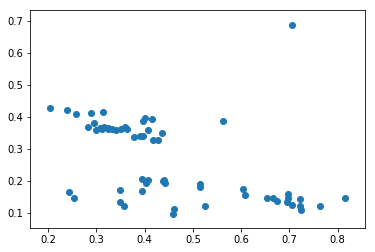

In [236]:
Results1 = Results1[Results1.index>1]
Results2 = Results2[Results2.index>1]
Results3 = Results3[Results3.index>1]
Results4 = Results4[Results4.index>1]
Results = pd.concat([Results1,Results2,Results3,Results4])
Results_light = Results[Results["PAR"]>0]
#plt.scatter(np.array(Results_light["Y(NPQ)"]),np.array(Results_light["Y(ND)"]))
plt.scatter(np.array(Results_light["Rel Fdred"]),np.array(Results_light["Y(NA)"]))
plt.show()

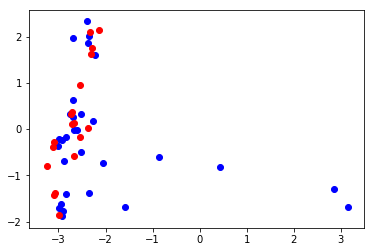

In [19]:
feature_names = ['Y(II)','ETR(II)', 'Y(NO)', 'Y(NPQ)', 'NPQ', 'qN', 'qL','P700ox', 'Y(I)', 'Y(ND)', 'Y(NA)', 'ETR(I)', 
        'Rel PCox', 'Rel Fdred',"Rel Fdm'", 'P700 k', 'PC k', 'Fd k',"P700 t1/2","PC t1/2","Fd t1/2"]
Results_light = Results[Results["PAR"]>0]
x = Results_light[feature_names[:]].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled = 2*x_scaled - 1 # centre at zero
#normalised_df = pd.DataFrame(x_scaled,columns = feature_names)

U, s, Vt = np.linalg.svd(x_scaled)
W2 = Vt.T[:,:2]
X2D = x_scaled.dot(W2)
X2D_NSS = X2D[Results_light["Class"]=="N"]
X2D_SS = X2D[Results_light["Class"]=="S"]


plt.scatter(np.array(X2D_NSS[:,0]).T,np.array(X2D_NSS[:,1]).T,color="b")
plt.scatter(np.array(X2D_SS[:,0]).T,np.array(X2D_SS[:,1]).T,color="r")
plt.show()

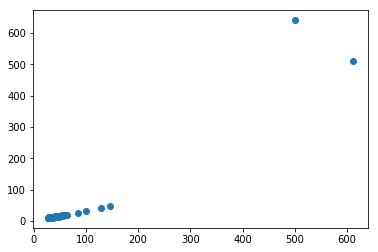

In [36]:
plt.scatter(np.array(Results_light["PC t1/2"]),np.array(Results_light["P700 t1/2"]))

In [159]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error

feature_names = ['PAR', 'Y(II)', 'ETR(II)', 'Y(NO)', 'Y(NPQ)', 'NPQ', 'qN', 'qP', 'qL', 'Y(I)', 'Y(ND)', 'Y(NA)', 'ETR(I)',
        'Rel PCox','Rel Fdred','1-qL', 'Y(I)/Y(II)','ETR(I)-ETR(II)']
output_variable = "Fd t1/2"
X = Results[feature_names]
X.replace([np.inf, -np.inf], np.nan)
X.dropna()
y = Results[output_variable]

# We want to do a train/test split

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2,random_state = 0) # default is 75% train


regr = linear_model.LinearRegression()
regr.fit(train_X,train_y)
print(regr.coef_,regr.intercept_)
yhat = regr.predict(val_X)

val_mae = mean_absolute_error(val_y,yhat)
fraction_error = np.abs(val_y-yhat)/val_y

print("Mean error (fraction)", np.mean(fraction_error))
print("Mean absolute error",val_mae)

[-8.96994059e-02 -4.05886181e+03  7.39194600e-01  2.12043157e+03
  3.66904698e+03 -6.43309515e+01 -1.27867810e+03  1.85964886e+03
  3.22124315e+02 -1.19477193e+02 -1.27498090e+03 -1.59192784e+03
  1.07668911e-01 -1.53440591e+03 -5.28703556e+02 -3.22124315e+02
 -7.20191046e+01 -6.31525657e-01] 1555.2452569668549
Mean error (fraction) 1.0882872278236964
Mean absolute error 96.47354231819585


In [157]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=3, random_state=0)
model.fit(train_X,train_y)
yhat = model.predict(val_X)

val_mae = mean_absolute_error(val_y,yhat)
fraction_error = np.abs(val_y-yhat)/val_y

print("Mean error (fraction)", np.mean(fraction_error))
print("Mean absolute error",val_mae)

Mean error (fraction) 0.2316757316757317
Mean absolute error 11.308566433566433


[ 57.75        31.5        488.59090909  32.83333333] [ 26.95666119  33.89098983 734.92558243 139.20850063]


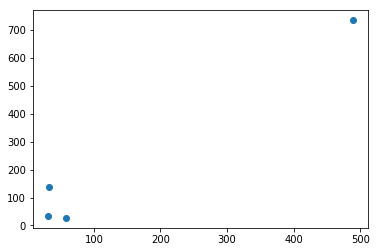

In [160]:
print(np.array(val_y),np.array(yhat))
plt.scatter(np.array(val_y),np.array(yhat))
plt.show()

In [161]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=4, max_depth = 3)
rf_small.fit(train_X,train_y)
# Extract the small tree
tree_small = rf_small.estimators_[3]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_names, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [162]:
from sklearn.tree import DecisionTreeRegressor  
  
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0,max_depth=3)  
  
# fit the regressor with X and Y data 
regressor.fit(train_X,train_y)
# import export_graphviz 
from sklearn.tree import export_graphviz  
  
# export the decision tree to a tree.dot file 
# for visualizing the plot easily anywhere 
#export_graphviz(regressor, out_file ='tree.dot', 
#               feature_names =feature_names)  
export_graphviz(regressor, out_file = 'tree.dot', feature_names = feature_names, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png');

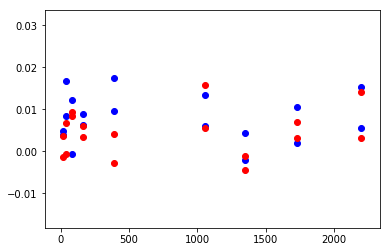

In [50]:
# steady state
Results1 = pd.read_csv(r"/media/will/3930-2B1A/LightCurve_12_07_19/Experiment1/Results.CSV")
Results2 = pd.read_csv(r"/media/will/3930-2B1A/LightCurve_12_07_19/Experiment2/Results.CSV")
Results3 = pd.read_csv(r"/media/will/3930-2B1A/LightCurve_12_07_19/Experiment3/Results.CSV")
Results4 = pd.read_csv(r"/media/will/3930-2B1A/LightCurve_12_07_19/Experiment4/Results.CSV")

Results_SP = pd.concat([Results1,Results3])
Results_DIRK = pd.concat([Results2,Results4])
Results_SP = Results_SP[Results_SP["PAR"]>5]
Results_DIRK = Results_DIRK[Results_DIRK["PAR"]>5]
#plt.scatter(np.array(Results_light["Y(NPQ)"]),np.array(Results_light["Y(ND)"]))
plt.scatter(np.array(Results_SP["PAR"]),np.array(Results_SP["Fd k"]),color="b")
plt.scatter(np.array(Results_DIRK["PAR"]),np.array(Results_DIRK["Fd k"]),color="r")
#plt.scatter(np.array(Results_SP["PC k"]),np.array(Results_DIRK["PC k"]),color="r")


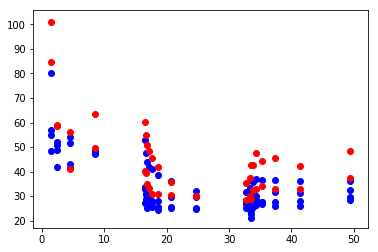

In [51]:
# steady state
Results1 = pd.read_csv(r"/media/will/3930-2B1A/LL_HL_LL_09_07_19/Experiment1/Results.CSV")
Results2 = pd.read_csv(r"/media/will/3930-2B1A/LL_HL_LL_09_07_19/Experiment2/Results.CSV")
Results3 = pd.read_csv(r"/media/will/3930-2B1A/LL_HL_LL_09_07_19/Experiment3/Results.CSV")
Results4 = pd.read_csv(r"/media/will/3930-2B1A/LL_HL_LL_09_07_19/Experiment4/Results.CSV")
Results5 = pd.read_csv(r"/media/will/3930-2B1A/LL_HL_LL_09_07_19/Experiment5/Results.CSV")
Results6 = pd.read_csv(r"/media/will/3930-2B1A/LL_HL_LL_09_07_19/Experiment6/Results.CSV")

Results_SP = pd.concat([Results1,Results2,Results3,Results4])
Results_DIRK = pd.concat([Results5,Results6])
Results_SP = Results_SP[Results_SP["Time/min"]>1]
Results_DIRK = Results_DIRK[Results_DIRK["Time/min"]>1]
#plt.scatter(np.array(Results_light["Y(NPQ)"]),np.array(Results_light["Y(ND)"]))
plt.scatter(np.array(Results_SP["Time/min"]),np.array(Results_SP["Fd t1/2"]),color="b")
plt.scatter(np.array(Results_DIRK["Time/min"]),np.array(Results_DIRK["Fd t1/2"]),color="r")
#plt.scatter(np.array(Results_SP["P700 t1/2"]),np.array(Results_DIRK["P700 t1/2"]),color="r")